### Load modules

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

from IPython import display
from utils import Logger 

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import trimesh
import trimesh.voxel.creation
import rtree

In [3]:
from torch.utils.data import Dataset

In [4]:
import scipy.ndimage as ndimage

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [6]:
from os import listdir
from os.path import join

In [7]:
torch.set_printoptions(profile="full")

### Load .obj files

In [8]:
data_folder='./inputs'

In [248]:
objects = []
for file in listdir(data_folder):
    if file.endswith(".stl"):
        m = trimesh.load_mesh(join(data_folder,file))
        #convert to voxels
        m_vox = trimesh.voxel.creation.voxelize(m,0.1)        
        objects.append(m_vox)
    

In [249]:
m_vox.show()

##### Pad tensors

In [250]:
# Define size of the space (pix)
scene_size = 64

In [251]:
# convert to tensors
vox_meshes = []
for m in objects:
    object_matrix = torch.from_numpy(m.matrix) # torch.ones(m.matrix.shape)
    scene_matrix = torch.zeros((scene_size,scene_size,scene_size))
    
    # center the matrices in the scene
    low = (int)(scene_matrix.size(0)//2) - (int)(object_matrix.size(0)//2)
    up = low + object_matrix.size(0)
    
    low1 = (int)(scene_matrix.size(1)//2) - (int)(object_matrix.size(1)//2)
    up1 = low1 + object_matrix.size(1)
    
    low2 = (int)(scene_matrix.size(2)//2) - (int)(object_matrix.size(2)//2)
    up2 = low2 + object_matrix.size(2)
    
    print(object_matrix.shape)
    scene_matrix[low:up,low1:up1,low2:up2] = object_matrix
    vox_meshes.append((scene_matrix))
    
#     matrix = torch.from_numpy(m.matrix) 
#     target = torch.zeros(scene_size,scene_size,scene_size)
#     source = torch.ones(matrix.shape)
#     target[:source.size(0), :source.size(1), :source.size(2)] = matrix
#     vox_meshes.append(target.reshape([1,scene_size,scene_size,scene_size]))

torch.Size([43, 43, 22])
torch.Size([25, 23, 14])
torch.Size([47, 47, 22])
torch.Size([29, 31, 14])
torch.Size([45, 45, 25])
torch.Size([27, 27, 10])
torch.Size([63, 63, 25])
torch.Size([45, 45, 21])
torch.Size([27, 27, 14])


In [252]:
vox_meshes[0]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

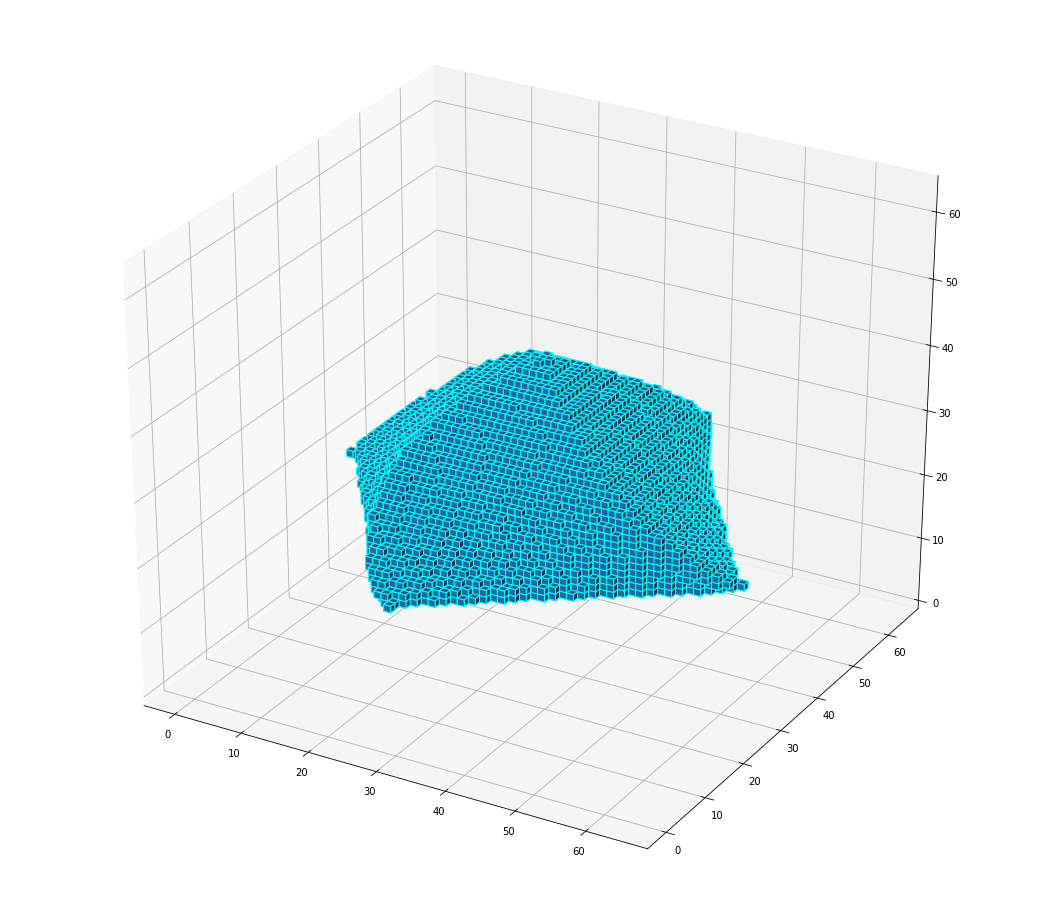

In [253]:
#show a sample

colors = np.empty(vox_meshes[6].shape, dtype=object)
fig = plt.figure()
fig.set_size_inches(18.5, 16.5)
ax = fig.gca(projection='3d')
ax.voxels(vox_meshes[6], edgecolor='cyan')
plt.show()

In [254]:
#dataset class
class object_dataset(Dataset):
    def __init__(self):
        self.samples = vox_meshes

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [255]:
input_data = object_dataset() #load the data

### My Networks

In [256]:
class DiscriminatorNet(torch.nn.Module):
    
    #3 hidden-layer discriminative nn
    
    def __init__(self, scene_size):
        super(DiscriminatorNet, self).__init__()
        self.n_features = scene_size * scene_size * scene_size
        self.n_out=1
        self.scene_size = scene_size
        
        pad = (0,0,0)
        pad1 = (1,1,1)
        if self.scene_size == 32:
            pad = (1,1,1)
            
        self.conv1 = nn.Sequential(
            torch.nn.Conv3d(1, self.scene_size, kernel_size=4, stride=2, bias=False, padding= pad1),
            torch.nn.BatchNorm3d(self.scene_size),
            torch.nn.LeakyReLU(0.2)
        )
        
        self.conv2 = nn.Sequential(
        torch.nn.Conv3d(self.scene_size,self.scene_size*2,kernel_size=4,stride=2,bias=False,padding=pad1),
        torch.nn.BatchNorm3d(self.scene_size*2),
        torch.nn.LeakyReLU(0.2)
        )
        
        self.conv3 = nn.Sequential(
        torch.nn.Conv3d(self.scene_size*2, self.scene_size*4,kernel_size=4,stride=2, bias=False, padding= pad1),
        torch.nn.BatchNorm3d(self.scene_size*4),
        torch.nn.LeakyReLU(0.2)
        )
        
        self.conv4 =  nn.Sequential(
        torch.nn.Conv3d(self.scene_size*4,self.scene_size*8,kernel_size=4, stride=2, bias=False, padding= pad1),
        torch.nn.BatchNorm3d(self.scene_size*8),
        torch.nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
        torch.nn.Conv3d(self.scene_size*8,1,kernel_size=4, stride=2, bias=False, padding= pad),
        torch.nn.Sigmoid()
        )

        
    def forward(self, x):
        x = x.view(-1, 1, self.scene_size, self.scene_size, self.scene_size)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out(x)
        return x

        


In [257]:
disc = DiscriminatorNet(64)
disc

DiscriminatorNet(
  (conv1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Sequential(
    (0): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Leaky

In [258]:
class GeneratorNet(torch.nn.Module):
    
    #3 hidden-layer discriminative nn
    
    def __init__(self, scene_size , n_features ):
        super(GeneratorNet, self).__init__()
        self.scene_size = scene_size
        self.n_features = n_features
        self.n_out=1
        
        pad1 = (1,1,1)
        pad = (0,0,0)
        if self.scene_size == 32:
            pad = (1,1,1)
            
        self.conv1 = nn.Sequential(
            torch.nn.ConvTranspose3d(self.n_features, self.scene_size * 8, kernel_size=4, stride=2, bias=False, padding= pad),
            torch.nn.BatchNorm3d(self.scene_size*8),
            torch.nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size*8,self.scene_size*4,kernel_size=4,stride=2,bias=False,padding=pad1),
        torch.nn.BatchNorm3d(self.scene_size*4),
        torch.nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size*4, self.scene_size*2,kernel_size=4,stride=2, bias=False, padding= pad1),
        torch.nn.BatchNorm3d(self.scene_size*2),
        torch.nn.ReLU()
        )
        
        self.conv4 =  nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size*2,self.scene_size,kernel_size=4, stride=2, bias=False, padding= pad1),
        torch.nn.BatchNorm3d(self.scene_size),
        torch.nn.ReLU()
        )
        
        self.out = nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size,self.n_out,kernel_size=4, stride=2, bias=False, padding= pad1),
        torch.nn.Sigmoid()
        )

        
    def forward(self, x):
        x = x.view(-1, self.n_features, 1,1,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out(x)
        return x

        


#### Create the model

In [259]:
class adversarialModel(object):
    def __init__(self, num_epochs=100, samples=3, batch=3, betas=(0.5,0.5),
                g_lr=0.002, d_lr=0.001, size=64, lat_vec =200,
                data_path='output/models/', transforms=None):
        #define parameters
        self.num_epochs=num_epochs
        self.samples = samples
        self.batch = batch
        self.betas = betas
        self.g_lr = g_lr
        self.d_lr = d_lr
        self.size = size
        self.latent = lat_vec
        self.dataset = 'input_data'
        self.name = 'voxModel'
        
        #define networks
        self.generator = GeneratorNet(scene_size=scene_size,n_features=self.latent)
        self.discriminator = DiscriminatorNet(scene_size = scene_size)
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=self.d_lr, betas=self.betas)
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=self.d_lr, betas=self.betas)
        self.loss = nn.BCELoss()
        
        self.generator.cuda()
        self.discriminator.cuda()
        
        #data
        data_set = object_dataset()
        self.data_loader = torch.utils.data.DataLoader(data_set, batch_size=self.batch, shuffle=True, num_workers=0)
        
    def train(self):
        
        for epoch in range(self.num_epochs):
            print('Epoch : ', epoch)
            
            for i,x in enumerate(self.data_loader):
                print('Batch : ', i)
                x = x.cuda()
                
                if(x.size()[0] != self.batch):
                    print('Batch size incompatible')
                    continue
                
                
                z = make_noise(self.batch, self.latent)
                z = z.cuda()
                
                #train discriminator
                prediction_real = self.discriminator(x)
               
                d_real_loss = self.loss(prediction_real,real_data_target(prediction_real.size(0)))
                
                fake_samples = self.generator(z)
                print(fake_samples.shape)
                prediction_fake = self.discriminator(fake_samples)
                d_fake_loss = self.loss(prediction_fake, fake_data_target(self.batch))
                
                d_total_loss = d_real_loss + d_fake_loss
                
                #check if accuracy is below some limit and reset gradient
                d_real_acuracy = torch.ge(prediction_real.squeeze(), 0.5).float()
                d_fake_acuracy = torch.le(prediction_fake.squeeze(), 0.5).float()
                d_total_acuracy = torch.mean(torch.cat((d_real_acuracy,d_fake_acuracy),0))
                
                if d_total_acuracy <= 0.7:
                    self.discriminator.zero_grad()
                    d_total_loss.backward(retain_graph=True)
                    self.d_optimizer.step()
                    
                #regenerate samples and train generator
                z = make_noise(self.batch, self.latent)
                z = z.cuda()
                fake_samples = self.generator(z)
                prediction_fake = self.discriminator(fake_samples)
                g_loss = self.loss(prediction_fake, real_data_target(prediction_fake.size(0)))
                
                #zero all gradients
                self.discriminator.zero_grad()
                self.generator.zero_grad()
                g_loss.backward()
                self.g_optimizer.step()
                
                if epoch%10 == 0 : 
                    print('discriminator loss: ',d_total_loss, '  generator loss: ', g_loss)
                    print('accuracy: ',d_total_acuracy)
                    #display_samples(fake_samples)
                    print(fake_samples.shape)
                
                
                
        

#### Display function

In [260]:
def display_samples(vox_to_display):
    vox_to_display = vox_to_display.cpu().data.squeeze().numpy()
    print(vox_to_display.shape)
    #get the values > number
    voxels = vox_to_display.__ge__(0.5)
    fig = plt.figure(figsize=(32, 16))
    gs = gridspec.GridSpec(2, 4)
    gs.update(wspace=0.05, hspace=0.05)

    #print(voxels)
    for i, sample in enumerate(voxels):
        #print(sample.shape)
        s = sample.nonzero()#.reshape([3,27000])
        
        colors = np.empty(nonzero[0].shape, dtype=object)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.voxels(s[0], edgecolor='cyan')
        plt.show()


Function to generate sample noise

In [261]:
def make_noise(size,latent):
    noise = torch.Tensor(size,latent).normal_(0, 0.33)
    return noise

Real and fake labels

In [262]:
def real_data_target(size):
    
    # Tensor containing ones(real)
    data = (torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    
    # Tensor containing ones(fake)    
    data = (torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

### Training

In [263]:
myModel = adversarialModel(num_epochs=2000, samples=3, batch=3, betas=(0.5,0.5),
          g_lr=0.0001, d_lr=0.0001, size=scene_size, lat_vec =100,data_path='output/models/', transforms=None)

In [264]:
myModel.train() #reaaaaally bad results :) 

Epoch :  0
Batch :  0
torch.Size([3, 1, 64, 64, 64])


C:\Users\Alexandra\ANACONDA3\lib\site-packages\torch\nn\modules\loss.py:516: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3, 1, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


discriminator loss:  tensor(1.4653, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(5.5719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.5000, device='cuda:0')
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(0.2539, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(3.0334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(0.4188, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.4121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 64, 64, 64])
Epoch :  1
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  2
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
tor

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  40
Batch :  0
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(0.9160, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(3.1088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.8333, device='cuda:0')
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(1.0192, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.7023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.8333, device='cuda:0')
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(0.8807, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.0990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.8333, device='cuda:0')
torch.Size([3, 1, 64, 64, 64])
Epoch :  41
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batc

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  79
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  80
Batch :  0
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(0.3822, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(2.0655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(0.5111, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(2.1958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(0.6005, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.8903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
ac

Epoch :  117
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  118
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  119
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  120
Batch :  0
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(0.5133, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.2143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.8333, device='cuda:0')
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(1.1351, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(2.8078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.8333, device='cuda:0')
torch.Size([3, 1, 64, 64, 64])
Batch 

Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  156
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  157
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  158
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  159
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  160
Batch :  0
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(3.2181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(0.2287, device='cuda:0', grad_fn=<AddBack

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  195
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  196
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  197
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  198
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  199
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  200
Batch :  0
torch.Size([3, 1, 64, 64, 64])
discriminator loss:  tensor(0.2975, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(3.2414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


Epoch :  233
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  234
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  235
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  236
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  237
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  238
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  239
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  240
Batch :  0
tor

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  272
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  273
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  274
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  275
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  276
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  277
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  278
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  312
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  313
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  314
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  315
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  316
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  317
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  318
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  352
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  353
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  354
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  355
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  356
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  357
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  358
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  392
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  393
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  394
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  395
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  396
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  397
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  398
Batch :  0
torch.Size([3, 1, 64, 64, 6

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  432
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  433
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  434
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  435
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  436
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  437
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  438
Batch :  0
torch.Size([3, 1, 64, 64, 6

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  472
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  473
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  474
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  475
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  476
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  477
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  478
Batch :  0
torch.Size([3, 1, 64, 64, 6

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  512
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  513
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  514
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  515
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  516
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  517
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  518
Batch :  0
torch.Size([3, 1, 64, 64, 6

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  552
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  553
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  554
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  555
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  556
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  557
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  558
Batch :  0
torch.Size([3, 1, 64, 64, 6

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  592
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  593
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  594
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  595
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  596
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  597
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  598
Batch :  0
torch.Size([3, 1, 64, 64, 6

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  632
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  633
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  634
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  635
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  636
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  637
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  638
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  672
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  673
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  674
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  675
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  676
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  677
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  678
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  712
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  713
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  714
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  715
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  716
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  717
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  718
Batch :  0
torch.Size([3, 1, 64, 64, 6

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  752
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  753
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  754
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  755
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  756
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  757
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  758
Batch :  0
torch.Size([3, 1, 64, 64, 6

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  792
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  793
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  794
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  795
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  796
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  797
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  798
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  832
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  833
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  834
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  835
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  836
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  837
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  838
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  872
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  873
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  874
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  875
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  876
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  877
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  878
Batch :  0
torch.Size([3, 1, 64, 64, 6

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  912
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  913
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  914
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  915
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  916
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  917
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  918
Batch :  0
torch.Size([3, 1, 64, 64, 6

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  952
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  953
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  954
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  955
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  956
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  957
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  958
Batch :  0
torch.Size([3, 1, 64, 64, 6

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  992
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  993
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  994
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  995
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  996
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  997
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  998
Batch :  0
torch.Size([3, 1, 64, 64, 6

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1032
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1033
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1034
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1035
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1036
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1037
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1038
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1072
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1073
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1074
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1075
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1076
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1077
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1078
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1112
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1113
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1114
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1115
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1116
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1117
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1118
Batch :  0
torch.Size([3, 1, 64

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1152
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1153
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1154
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1155
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1156
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1157
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1158
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Siz

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1192
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1193
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1194
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1195
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1196
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1197
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1198
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1232
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1233
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1234
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1235
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1236
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1237
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1238
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1272
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1273
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1274
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1275
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1276
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1277
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1278
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1312
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1313
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1314
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1315
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1316
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1317
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1318
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1352
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1353
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1354
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1355
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1356
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1357
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1358
Batch :  0
torch.Size([3, 1, 64

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1392
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1393
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1394
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1395
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1396
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1397
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1398
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Siz

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1432
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1433
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1434
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1435
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1436
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1437
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1438
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1472
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1473
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1474
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1475
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1476
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1477
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1478
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1512
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1513
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1514
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1515
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1516
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1517
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1518
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1552
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1553
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1554
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1555
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1556
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1557
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1558
Batch :  0
torch.Size([3, 1, 64

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1592
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1593
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1594
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1595
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1596
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1597
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1598
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Siz

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1632
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1633
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1634
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1635
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1636
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1637
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1638
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Siz

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1672
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1673
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1674
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1675
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1676
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1677
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1678
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1712
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1713
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1714
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1715
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1716
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1717
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1718
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1752
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1753
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1754
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1755
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1756
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1757
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1758
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1792
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1793
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1794
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1795
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1796
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1797
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1798
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1832
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1833
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1834
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1835
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1836
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1837
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1838
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1872
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1873
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1874
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1875
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1876
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1877
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1878
Batch :  0
torch.Size([3, 1, 64

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1912
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1913
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1914
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1915
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1916
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1917
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1918
Batch :  0
torch.Size([3, 1, 64

Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1952
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1953
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1954
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1955
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1956
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1957
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1958
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Siz

torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1992
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1993
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1994
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1995
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1996
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1997
Batch :  0
torch.Size([3, 1, 64, 64, 64])
Batch :  1
torch.Size([3, 1, 64, 64, 64])
Batch :  2
torch.Size([3, 1, 64, 64, 64])
Epoch :  1998
Batch :  0
torch.Size([3, 1, 64

In [290]:
some_noise = make_noise(1, 100)
some_noise = some_noise.cuda()
samples = myModel.generator(some_noise).cpu().data.numpy()
#samples

In [291]:
image = np.squeeze(samples,0)
positive = image.__ge__(0.00)
#positive

In [242]:
torch.autograd.set_detect_anomaly(True)

In [243]:
vox_to_display = myModel.fake_data.cpu().data.squeeze().numpy()
vox_to_display[0] 

AttributeError: 'adversarialModel' object has no attribute 'fake_data'

In [292]:
#I CAN FIND THE POSITIONS OF THE NON-ZERO ELEMENTS...CAN I USE THIS?

#get the values > number
voxels = image.__ge__(0.4)
fig = plt.figure(figsize=(32, 16))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.05, hspace=0.05)

print(voxels.shape)
#print(voxels)
for i, sample in enumerate(voxels):
        #print(sample.shape)
#         s = sample.nonzero()#.reshape([3,27000])
#         #print(s)
#         x,y,z = s
        
#         ax = plt.subplot(gs[i], projection='3d')
#         ax.scatter(x, y, z, zdir='z', c='red')
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
        
        fig = plt.figure()
        fig.set_size_inches(18.5, 16.5)
        ax = fig.gca(projection='3d')
        ax.voxels(voxels.squeeze())#, edgecolor='cyan')
        #ax.set_aspect('equal')
#plt.savefig(path + '{}.png'.format(str(iteration).zfill(3)), bbox_inches='tight')
#plt.close()


#print(test_vox[0].shape)
#v=test_vox[0].squeeze()#.reshape([3,8000])
#print(v.shape)
#ax.voxels(v)
#plt.show()

(1, 64, 64, 64)


<Figure size 2304x1152 with 0 Axes>

In [272]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import skimage
import skimage.measure

In [273]:
voxels.shape

(1, 64, 64, 64)

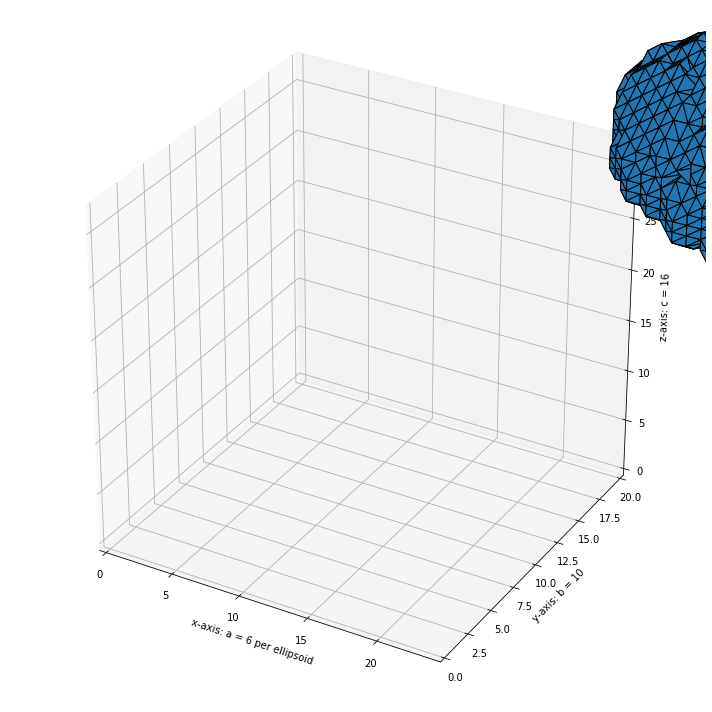

In [293]:
verts, faces, normals, values = skimage.measure.marching_cubes(voxels.squeeze(),0)
finMesh = trimesh.Trimesh(verts,faces)
finMesh = trimesh.smoothing.filter_humphrey(finMesh, alpha=0.1, beta=0.3, iterations=15, laplacian_operator=None)

fig = plt.figure(figsize=(10,10))

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])

mesh.set_edgecolor('k')
ax = fig.gca(projection='3d')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()

In [294]:
finMesh.export('dMesh_s.obj')

'# https://github.com/mikedh/trimesh\nv 33.20366527 33.14292526 32.99151183\nv 33.13506804 33.07848593 38.22846913\nv 32.97639105 33.18936488 35.99943567\nv 32.98310177 33.27610955 34.86285709\nv 33.27618145 40.78456970 30.75044965\nv 33.13134732 41.14653783 30.12423973\nv 32.82425591 40.51972395 26.80329879\nv 32.88456900 41.00468911 25.70962309\nv 33.03338742 40.84855243 33.80570907\nv 33.30912796 41.29721219 24.94658770\nv 33.04886259 23.86321836 31.91244597\nv 33.02402917 24.08117604 28.99019500\nv 33.03222629 23.97496863 34.16558745\nv 32.91565937 31.86193276 33.24363047\nv 32.62156539 32.01360841 38.63132258\nv 32.86379784 31.89337540 36.29359949\nv 32.98635365 32.07313860 34.58913591\nv 32.90780014 40.02414243 31.91458830\nv 32.97411862 40.27709378 31.13348799\nv 32.94309997 39.67898335 27.99995607\nv 33.04935317 40.03042851 34.59671715\nv 33.13440184 22.98251370 33.37450116\nv 32.92835525 22.87184316 32.10028694\nv 33.18530930 22.79182240 30.94923785\nv 33.03203604 23.37633621 